In [10]:
import os
from collections import defaultdict
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
data_dir = "../data"
os.listdir(data_dir)

['bus_stops_wszone.dbf',
 'bus_stops_wszone.shp',
 'net_202001_15.net',
 'OD_bus',
 'net_202001_05.net',
 'net_202001_06.net',
 'origin_destination_train_201912.csv.xz',
 'train_station_wszone.prj',
 'origin_destination_train_202001.csv.xz',
 'train_station_wszone.dbf',
 'OD_202001_weekend.csv.xz',
 'net_202001_22.net',
 'subzone_centroid.csv',
 'OD_201912_weekday.csv.xz',
 'origin_destination_bus_201911.csv.xz',
 'net_202001_19.net',
 'net_202001_18.net',
 'train_station_wszone.cpg',
 'OD_PT',
 'train_station_wszone.shx',
 'net_202001_10.net',
 'OD_201911_weekend.csv.xz',
 'origin_destination_train_201911.csv.xz',
 'net_202001_weekend.net',
 'subzone_centroid_pos.json',
 '.ipynb_checkpoints',
 'net_202001_21.net',
 'origin_destination_bus_202001.csv.xz',
 'OD_201912_weekend.csv.xz',
 'net_202001_07.net',
 'origin_destination_bus_201912.csv.xz',
 'net_202001_23.net',
 'region-2014',
 'train_station_wszone.shp',
 'net_202001_weekday.net',
 'net_202001_16.net',
 'OD_train',
 'bus_stops_w

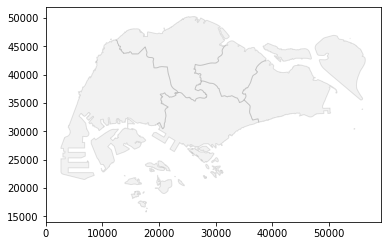

In [8]:
region = gpd.read_file("../data/region-2014/MP14_REGION_WEB_PL.shp")
region.plot(color="grey", edgecolor="k", alpha=0.1)

In [11]:
with open(os.path.join("../data", 'subzone_centroid_pos.json'), 'r') as fread:
    pos = json.load(fread)
pos["MARINA SOUTH"]

[31595.83574613999, 29220.18737674884]

In [12]:
weekday_res = pd.read_csv("Super_SR_weekday.csv", index_col=0)
weekend_res = pd.read_csv("Super_SR_weekend.csv", index_col=0)

In [13]:
weekday_res.head()

,node,cal_dc_spreader,cal_hh,cal_pr_spreader,cal_dc_receiver,cal_ha,cal_pr_receiver
ind,,,,,,,
0,TAMPINES EAST,0.572276,0.572276,0.533376,0.639755,0.635740,0.596268
1,BEDOK NORTH,0.360342,0.337404,0.338292,0.362057,0.340500,0.336666
2,TOA PAYOH CENTRAL,0.624277,0.303357,0.622293,0.631936,0.310269,0.632736
3,ALJUNIED,0.525679,0.322300,0.523547,0.497914,0.331237,0.481654
4,TAMPINES WEST,0.394065,0.431569,0.371555,0.322927,0.394873,0.295054


In [14]:
weekend_res.head()

,node,cal_dc_spreader,cal_hh,cal_pr_spreader,cal_dc_receiver,cal_ha,cal_pr_receiver
ind,,,,,,,
0,TAMPINES EAST,0.554046,0.554046,0.526039,0.602500,0.602500,0.572044
1,BEDOK NORTH,0.435241,0.413180,0.413432,0.433820,0.421214,0.409280
2,TOA PAYOH CENTRAL,0.661196,0.355419,0.666776,0.658458,0.359004,0.670499
3,ALJUNIED,0.490456,0.332743,0.485179,0.443276,0.333933,0.430377
4,TAMPINES WEST,0.318722,0.360123,0.308679,0.287690,0.359133,0.267098


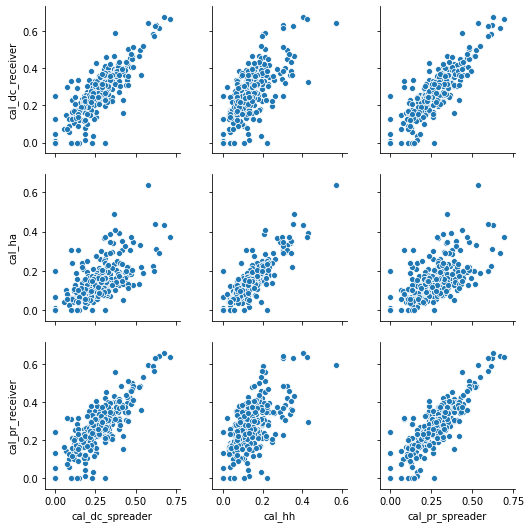

In [17]:
sns.pairplot(weekday_res,  x_vars=["cal_dc_spreader", "cal_hh", "cal_pr_spreader"], y_vars=["cal_dc_receiver","cal_ha","cal_pr_receiver"])

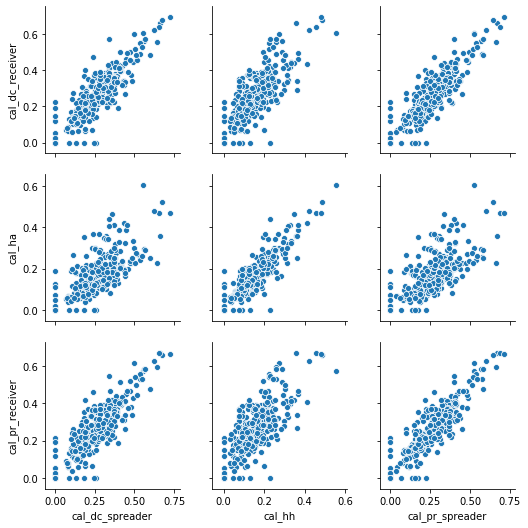

In [18]:
sns.pairplot(weekend_res,  x_vars=["cal_dc_spreader", "cal_hh", "cal_pr_spreader"], y_vars=["cal_dc_receiver","cal_ha","cal_pr_receiver"])

In [23]:
def get_top(df, col, top=10):
    df2 = df[["node", col]].sort_values(by=col, ascending=False)
    nodes = []
    done = False
    i = 0
    while not(done):
        row = df2.iloc[i]
        n = row["node"]
        v = row[col]
        nodes.append((n,v))
        i+=1
        if i>=top:
            if df2.iloc[i][col]!=v:
                done = True
    #print(len(nodes), nodes)
    return nodes
get_top(weekday_res, "cal_dc_spreader")

[('YISHUN CENTRAL', 0.7076367058909477),
 ('WOODLANDS REGIONAL CENTRE', 0.6745677061500274),
 ('JURONG WEST CENTRAL', 0.6439756655766382),
 ('TOA PAYOH CENTRAL', 0.6242768447492224),
 ('YISHUN WEST', 0.6156017032407197),
 ('CHOA CHU KANG CENTRAL', 0.6134705625087508),
 ('JELEBU', 0.6048607669712612),
 ('TAMPINES EAST', 0.5722755128032201),
 ('JURONG GATEWAY', 0.5428506261913704),
 ('YISHUN SOUTH', 0.5305800104939373)]

In [29]:
for col in [ col for col in weekday_res.columns if col!="node"]:
    top_ten = get_top(weekday_res, col)
    print(len(top_ten))
print()
for col in [ col for col in weekend_res.columns if col!="node"]:
    top_ten = get_top(weekend_res, col)
    print(len(top_ten))

10
10
10
10
10
10

10
10
10
10
10
10


In [39]:

def draw_fig(df, col, top=10, top2=0, cat=None):
    top_nodes = get_top(df, col, top=top+top2)
        
    xs = []
    ys = []
    cs = []
    fs = []
    ws = []
    colors = ["red", "blue"]
    for i in range(top+top2):
        n,v = top_nodes[i]
        x,y = pos[n]
        xs.append(x)
        ys.append(y)
        fs.append(v*1000)
        if i<top:
            cs.append(colors[0])
        else:
            cs.append(colors[1])
        
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_aspect("equal")
    region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)
    ax.set_xlim([4500,50000])
    ax.set_ylim([25000,50000])
    ax.scatter(xs, ys, s=fs, color=cs)

    #for i, txt in enumerate(ws):
    #    ax.annotate(txt, (xs[i], ys[i]))
    ax.set_title("{} - {}".format(cat, col))
    plt.tight_layout()
    #plt.savefig("2020-01-weekday-community.png", dpi=100, bbox_inches="tight")

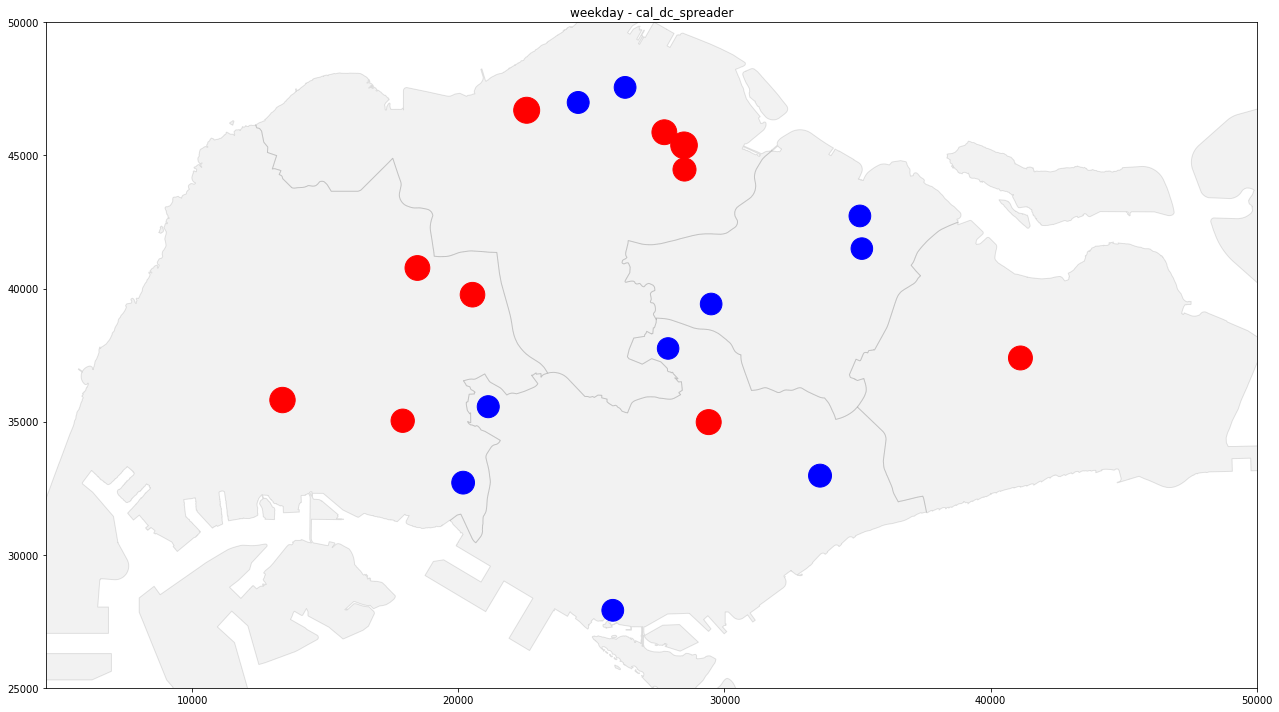

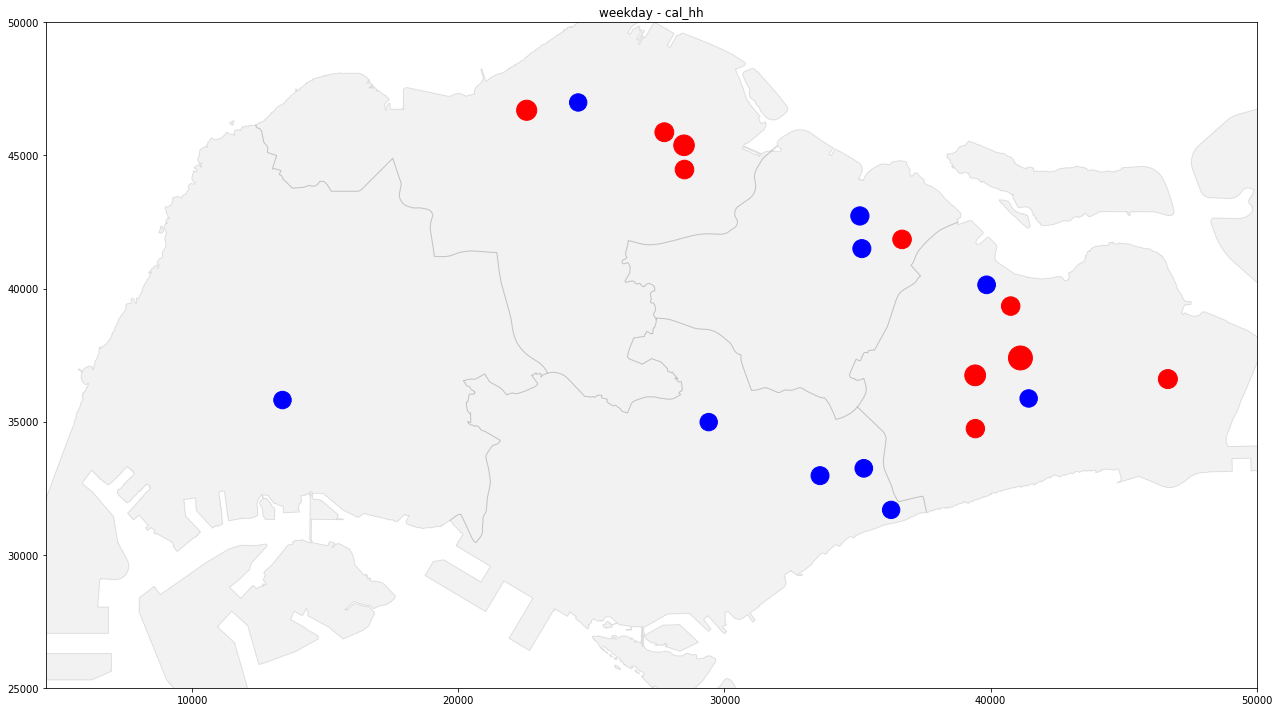

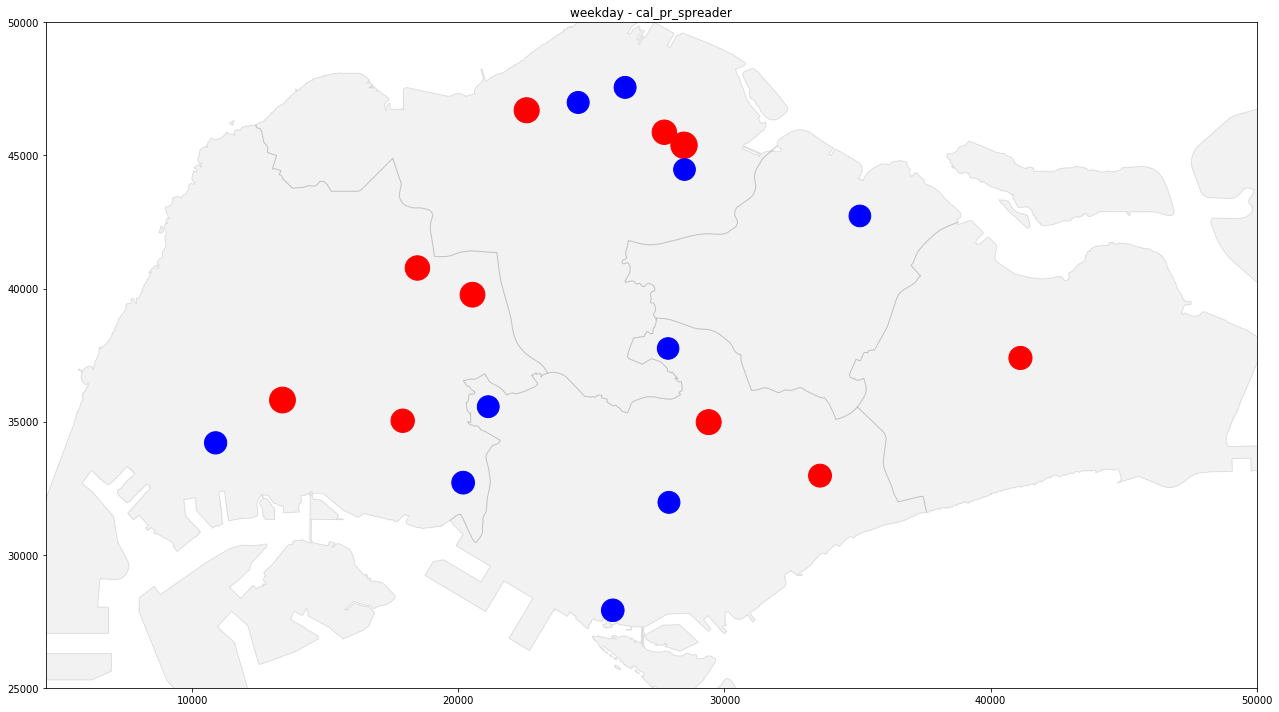

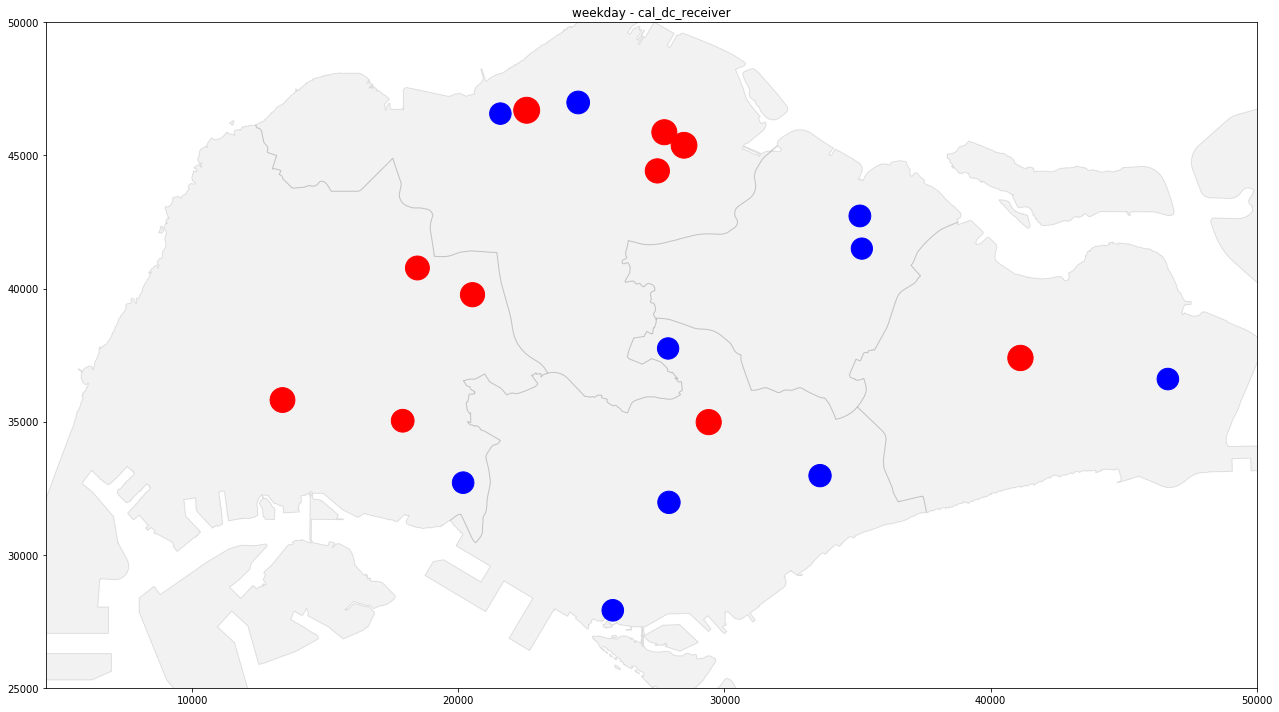

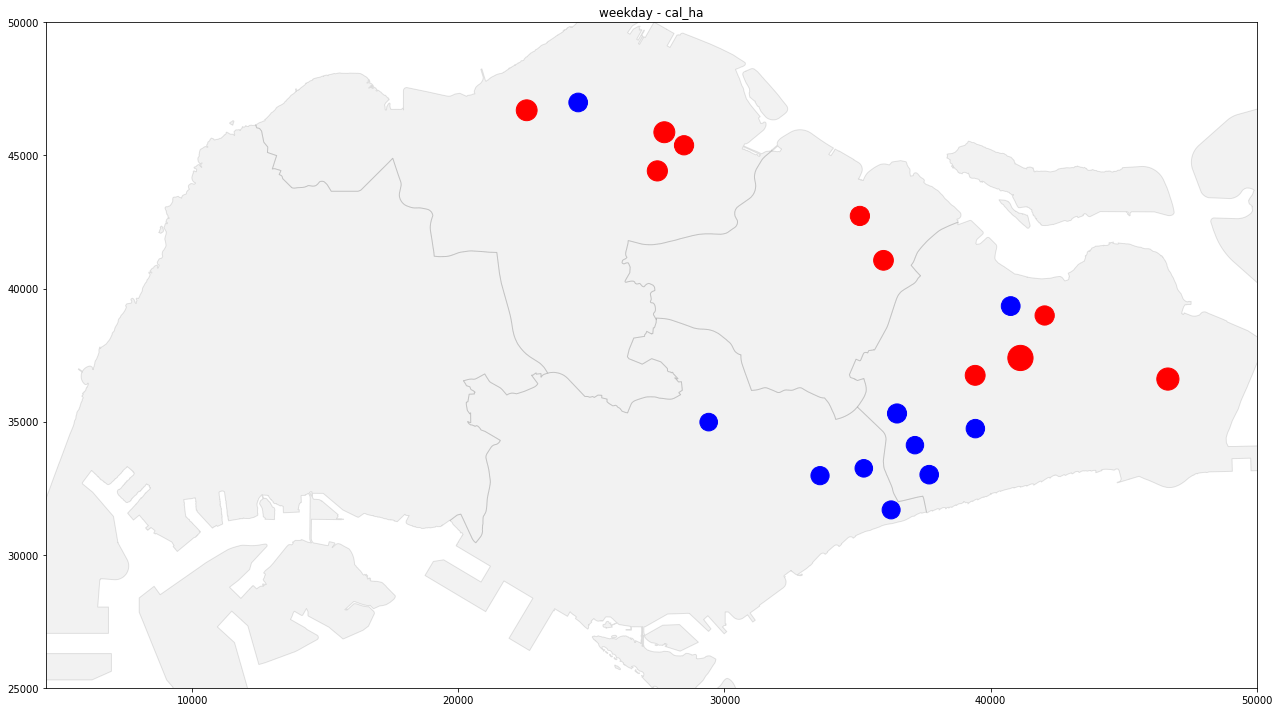

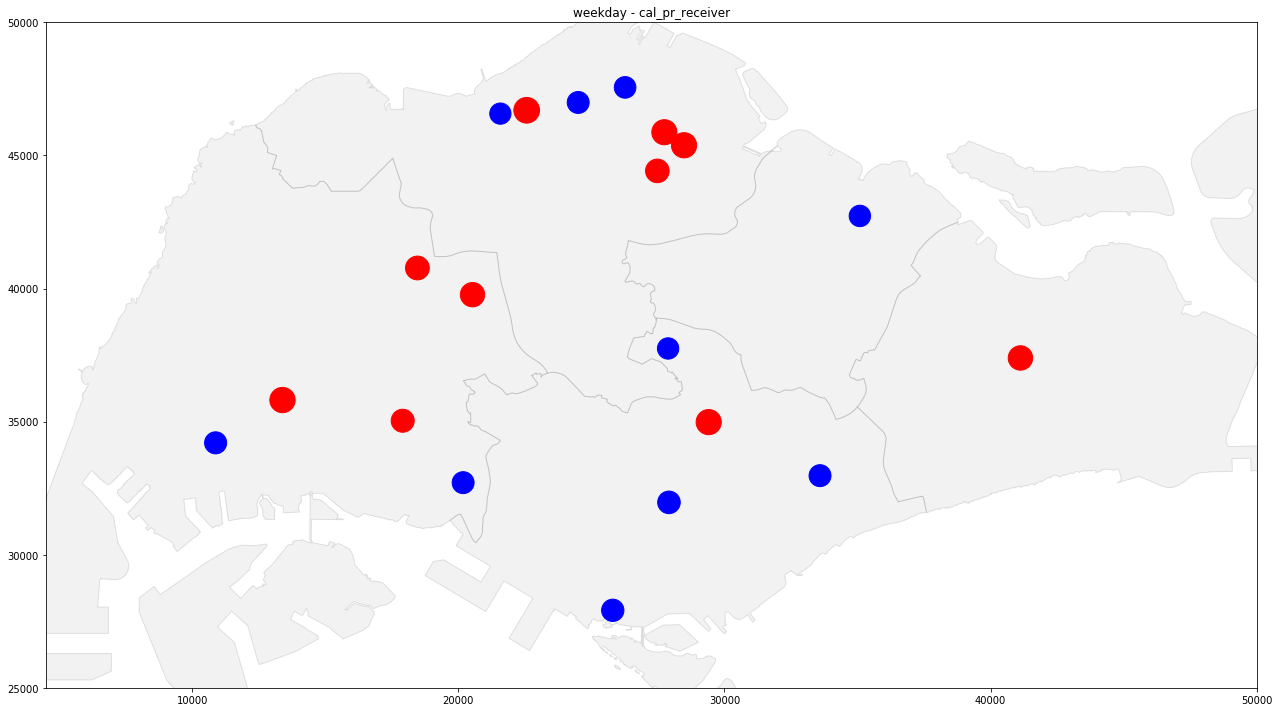

In [40]:
for col in [ col for col in weekday_res.columns if col!="node"]:
    #top_ten = get_top(weekday_res, col)
    draw_fig(weekday_res, col, top=10, top2=10, cat="weekday")

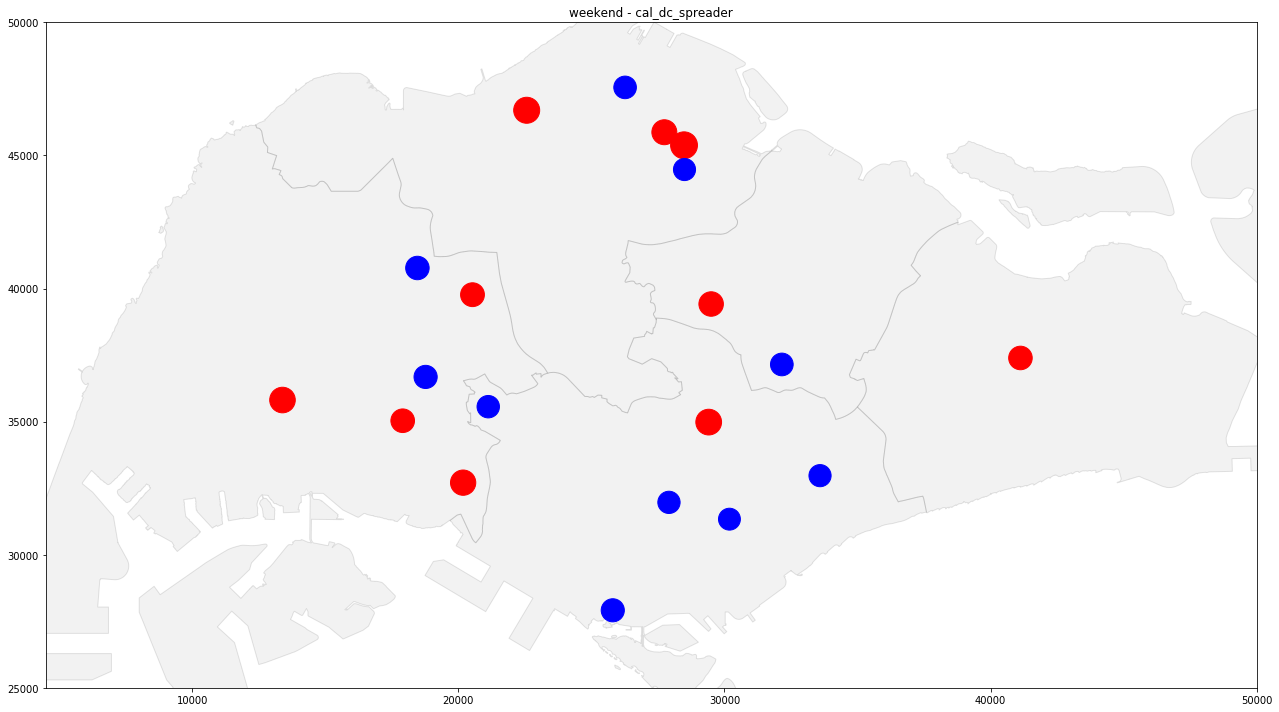

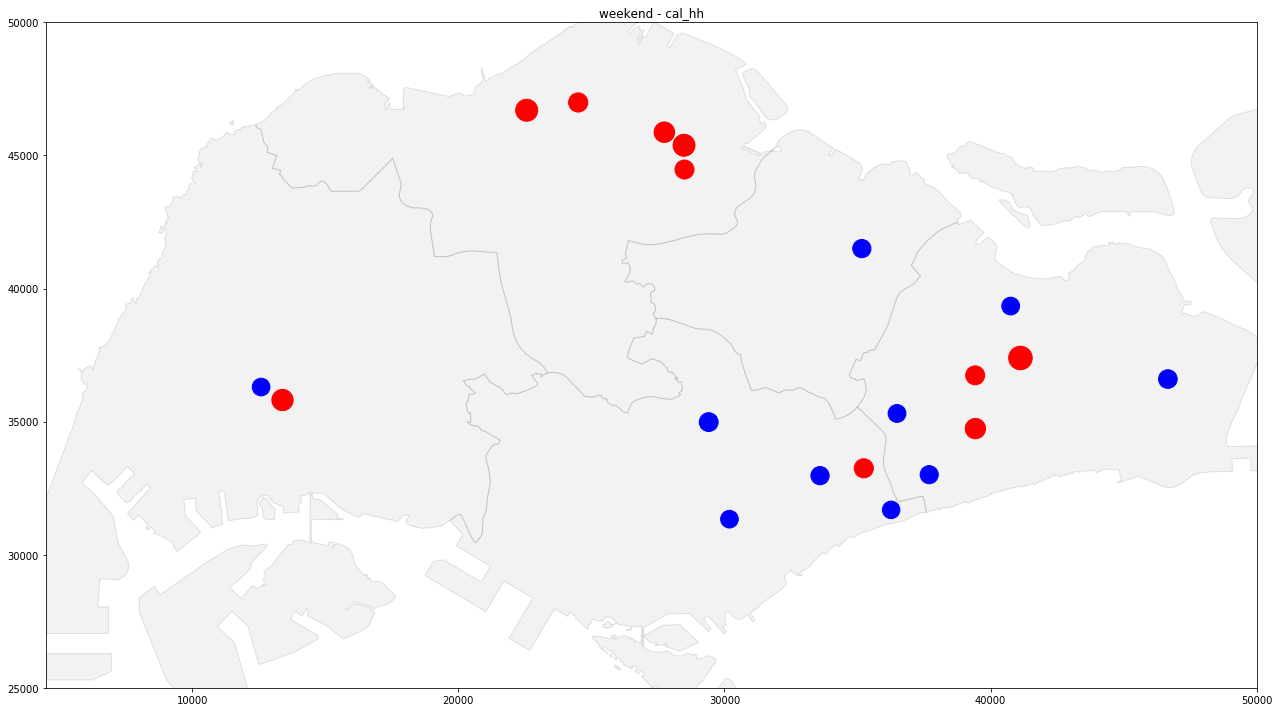

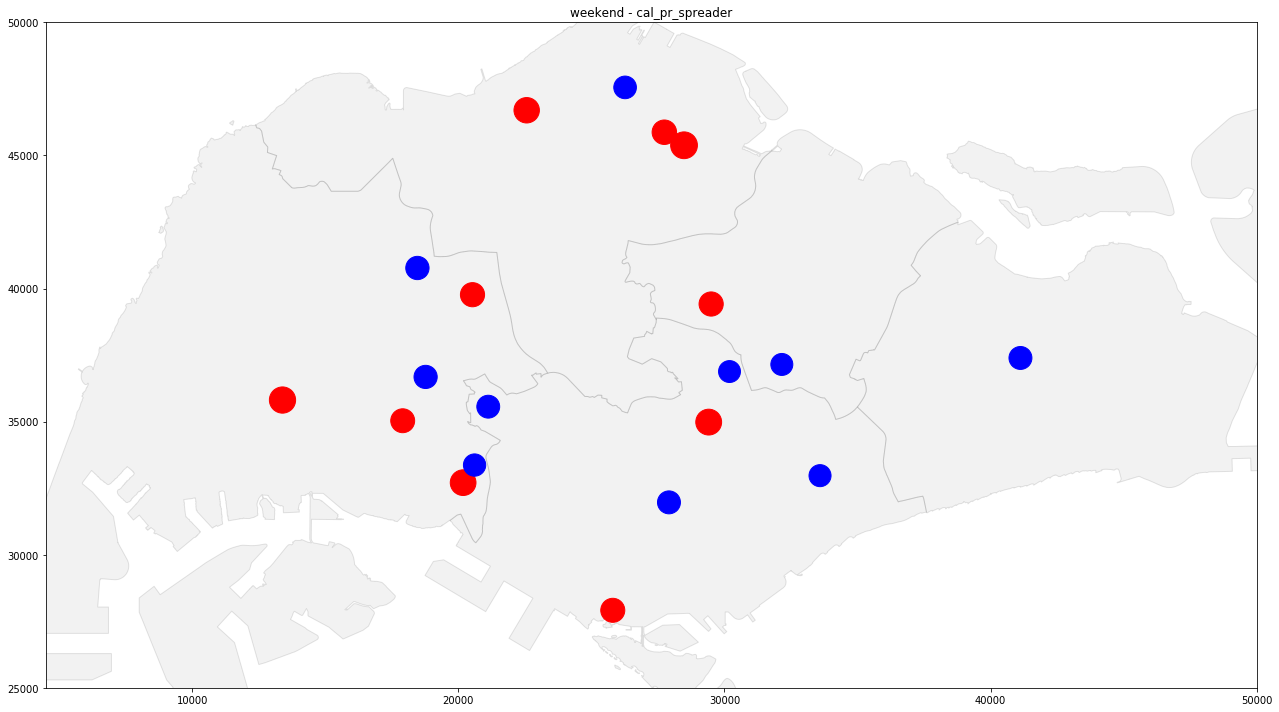

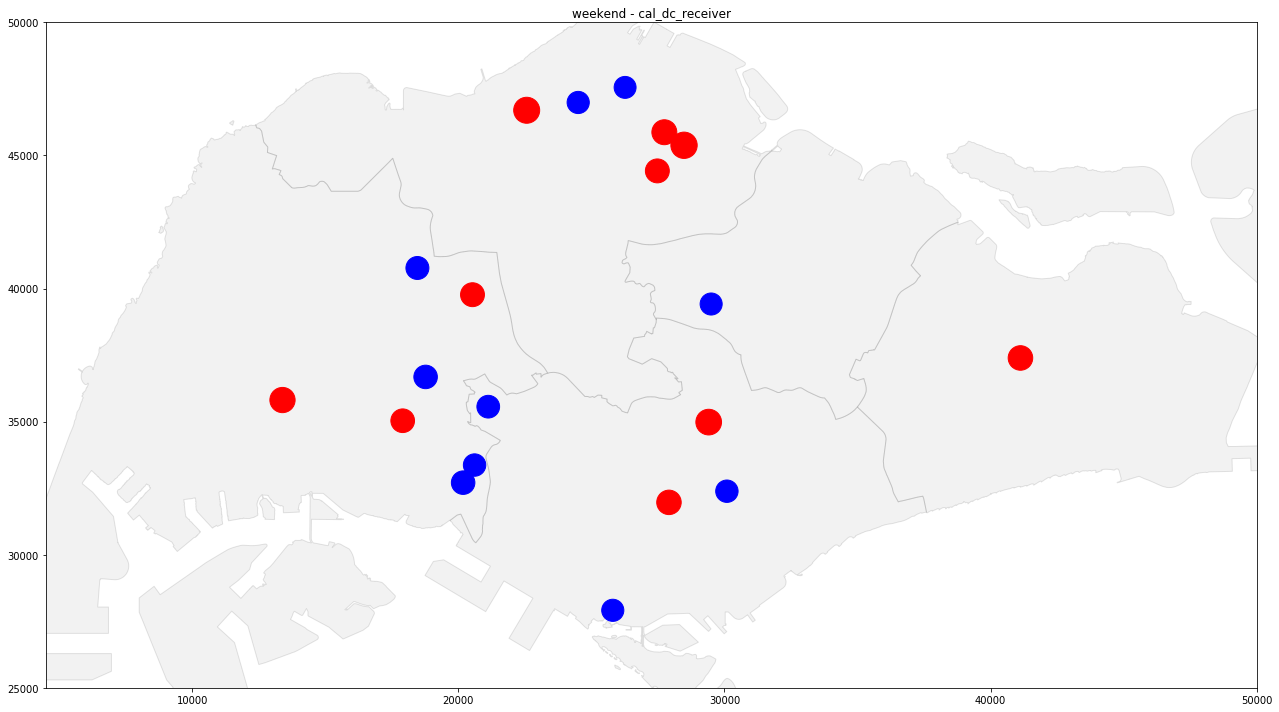

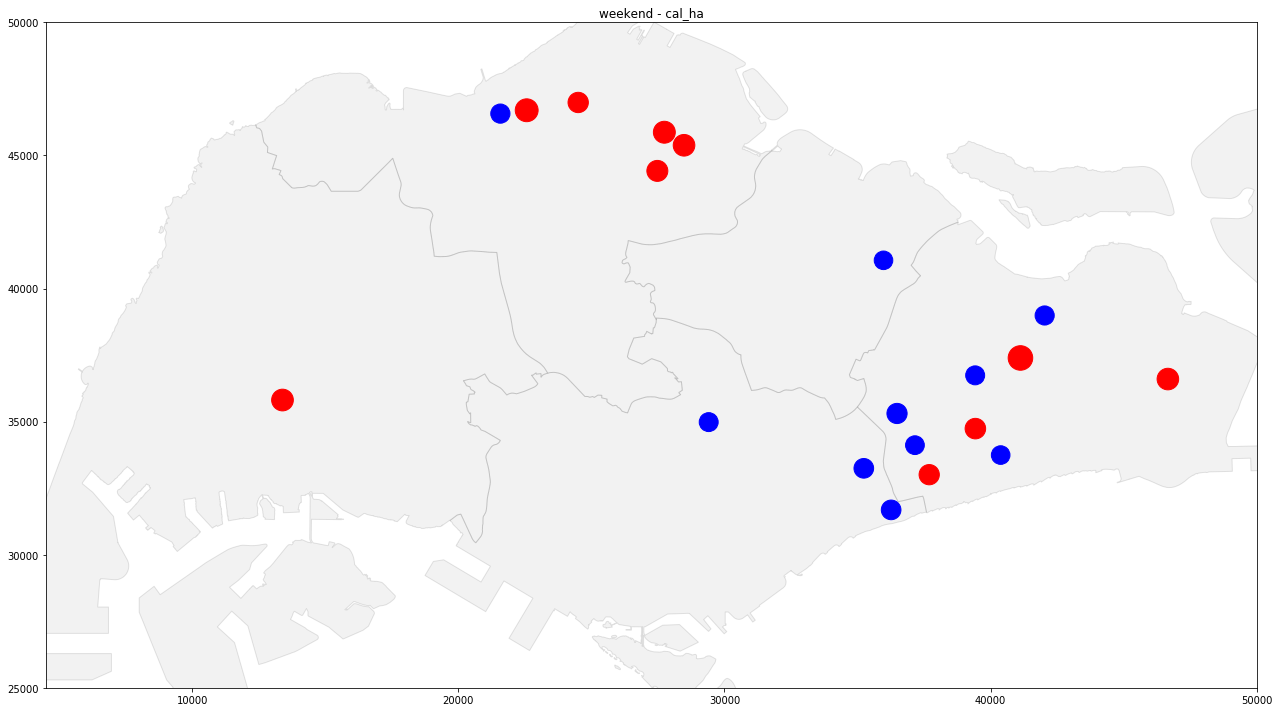

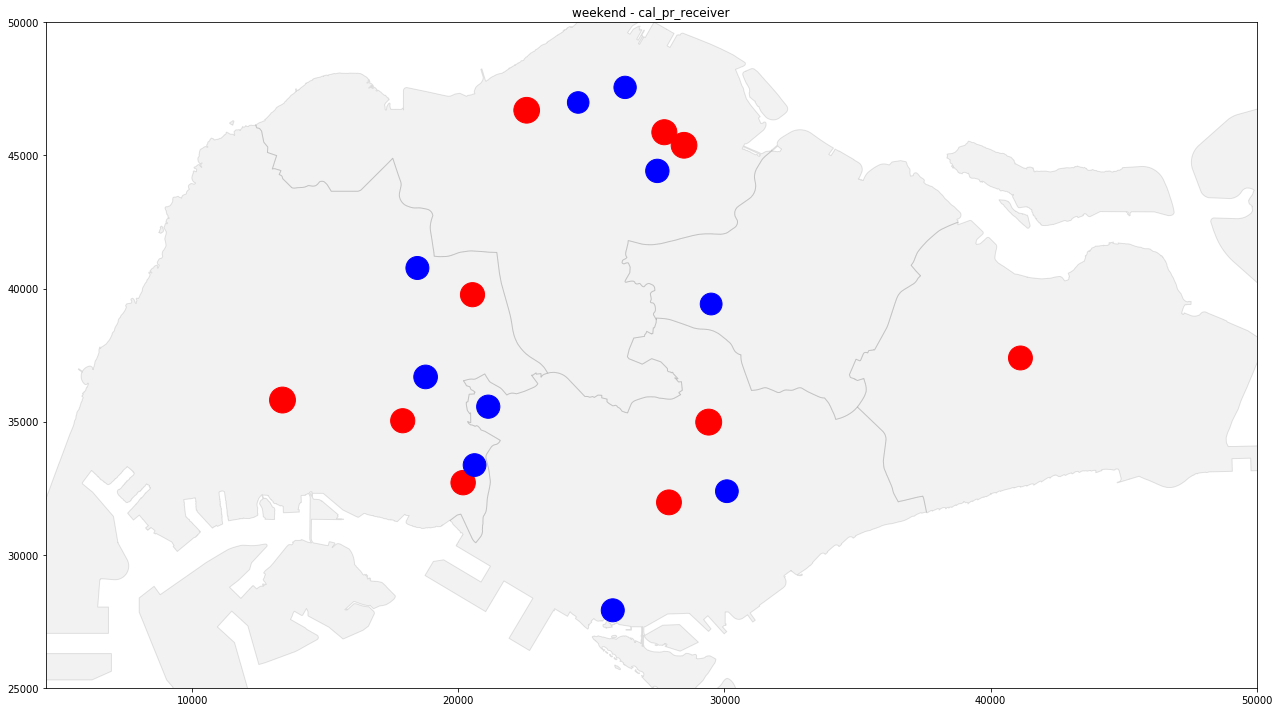

In [41]:
for col in [ col for col in weekend_res.columns if col!="node"]:
    draw_fig(weekend_res, col, top=10, top2=10, cat="weekend")

In [82]:
def draw_parallel(df, top=10, cols=None):
    if cols is None:
        cols = [ col for col in df.columns if col!="node"]
    top_nodes = set()
    nodes_val = {}
    for col in cols:
        nodes = get_top(df, col, top=top)
        nodes_val = {col: nodes}
        top_nodes = top_nodes | set([ n for n,v in nodes ])
    print(len(top_nodes), top_nodes)
    lines = []
    df2 = df.set_index("node")
    #print(df2.head())
    for n in top_nodes:
        line = []
        row = df2.loc[n]
        #print(row)
        for col in cols:
            line.append( row[col] )
        #print(line)
        lines.append(line)
        #break
    fig, ax = plt.subplots(figsize=(16,12))
    for line, n in zip(lines, top_nodes):
        ax.plot(line, label=n)
    for i in range(len(cols)):
        ax.axvline(x=i, ls=':', c='k')
    ax.set_xticks(list(range(len(cols))))
    ax.set_xticklabels(cols)
    ax.set_ylim([0,1])
    plt.legend()
    plt.tight_layout()

12 {'WOODLANDS REGIONAL CENTRE', 'YISHUN WEST', 'JELEBU', 'KHATIB', 'TOA PAYOH CENTRAL', 'YISHUN CENTRAL', 'JURONG WEST CENTRAL', 'JURONG GATEWAY', 'ALJUNIED', 'CHOA CHU KANG CENTRAL', 'TAMPINES EAST', 'YISHUN SOUTH'}


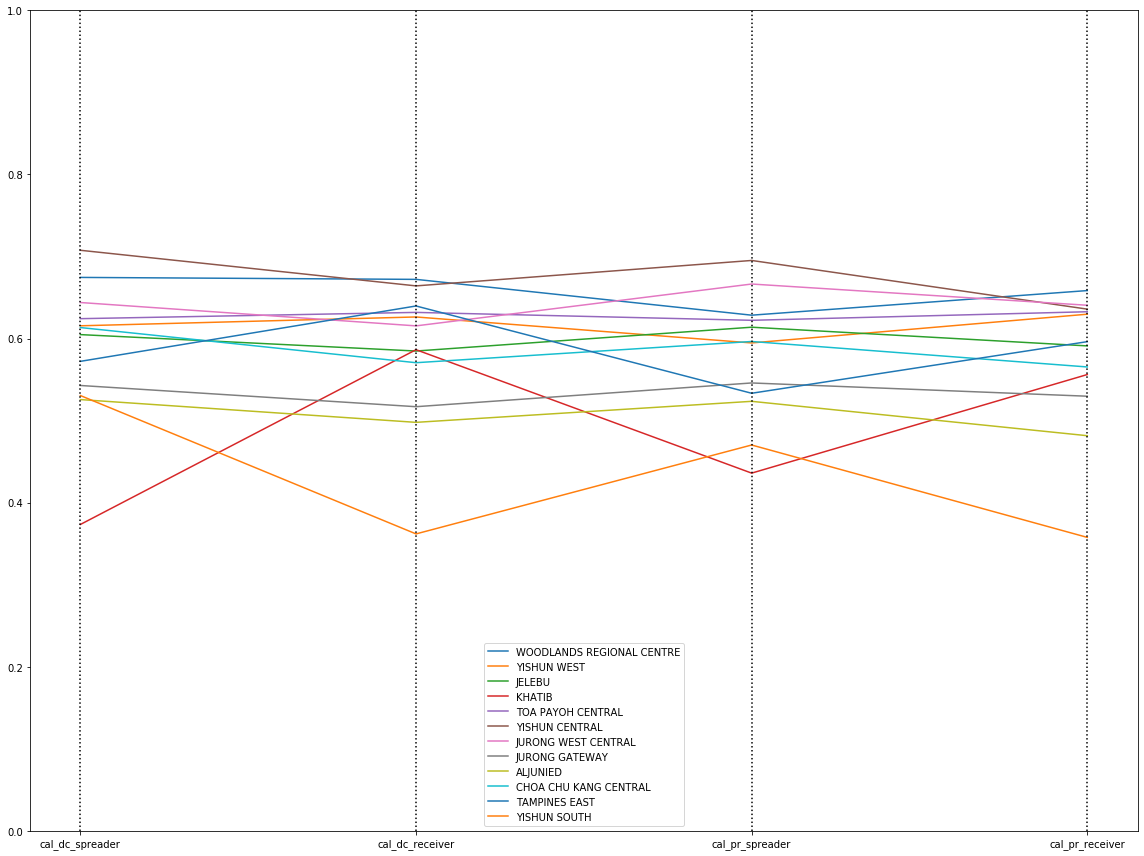

In [86]:
draw_parallel(weekday_res, top=10, cols=['cal_dc_spreader', 'cal_dc_receiver', 'cal_pr_spreader', 'cal_pr_receiver'])#, 'cal_hh',  'cal_ha'])

25 {'JELEBU', 'TOA PAYOH CENTRAL', 'JURONG GATEWAY', 'CLEMENTI CENTRAL', 'WOODLANDS EAST', 'MARITIME SQUARE', 'CHOA CHU KANG CENTRAL', 'YISHUN SOUTH', 'ANG MO KIO TOWN CENTRE', 'JOO KOON', 'WOODLANDS REGIONAL CENTRE', 'YISHUN WEST', 'KHATIB', 'CHANGI AIRPORT', 'WOODLANDS WEST', 'MATILDA', 'YISHUN CENTRAL', 'JURONG WEST CENTRAL', 'SEMBAWANG CENTRAL', 'SENGKANG TOWN CENTRE', 'ANAK BUKIT', 'ALJUNIED', 'UPPER THOMSON', 'TAMPINES EAST', 'BOULEVARD'}


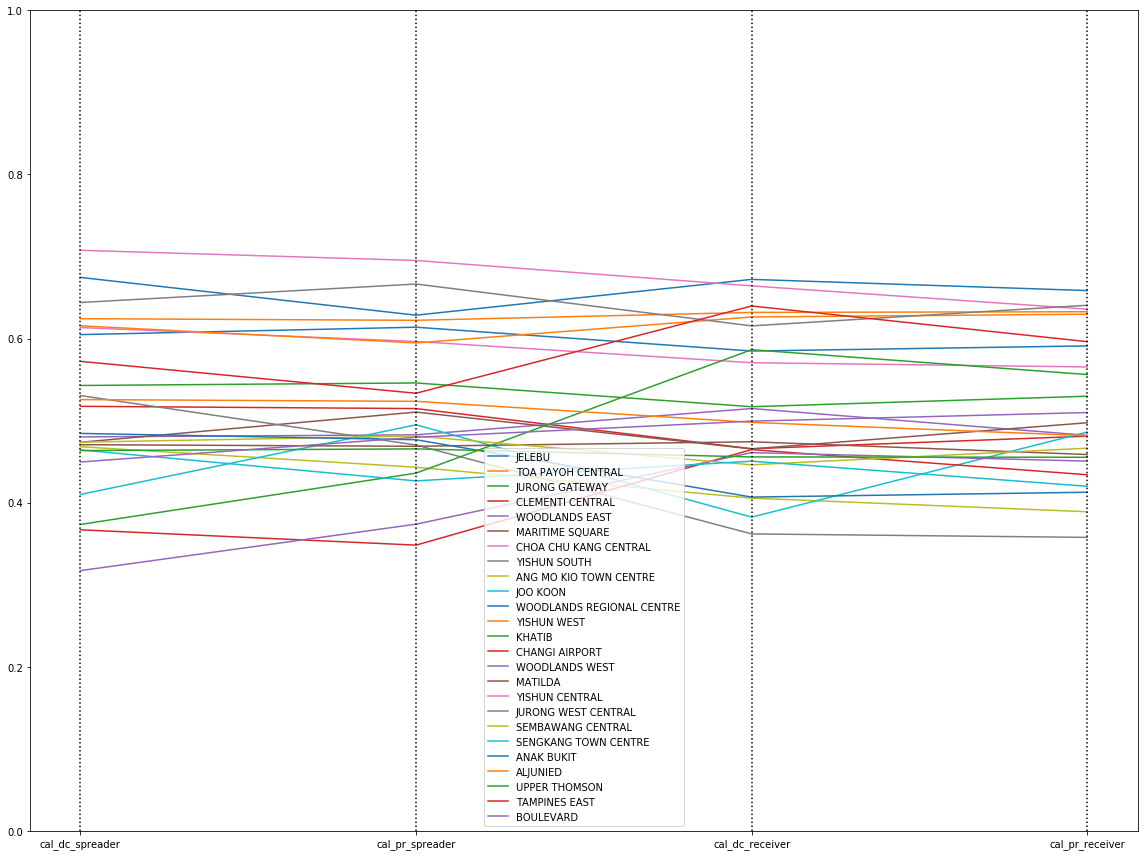

In [88]:
draw_parallel(weekday_res, top=20, cols=['cal_dc_spreader', 'cal_pr_spreader', 'cal_dc_receiver', 'cal_pr_receiver'])#, 'cal_hh',  'cal_ha'])

6 {'TOA PAYOH CENTRAL', 'WOODLANDS REGIONAL CENTRE', 'YISHUN CENTRAL', 'JURONG WEST CENTRAL', 'CLEMENTI CENTRAL', 'YISHUN WEST'}


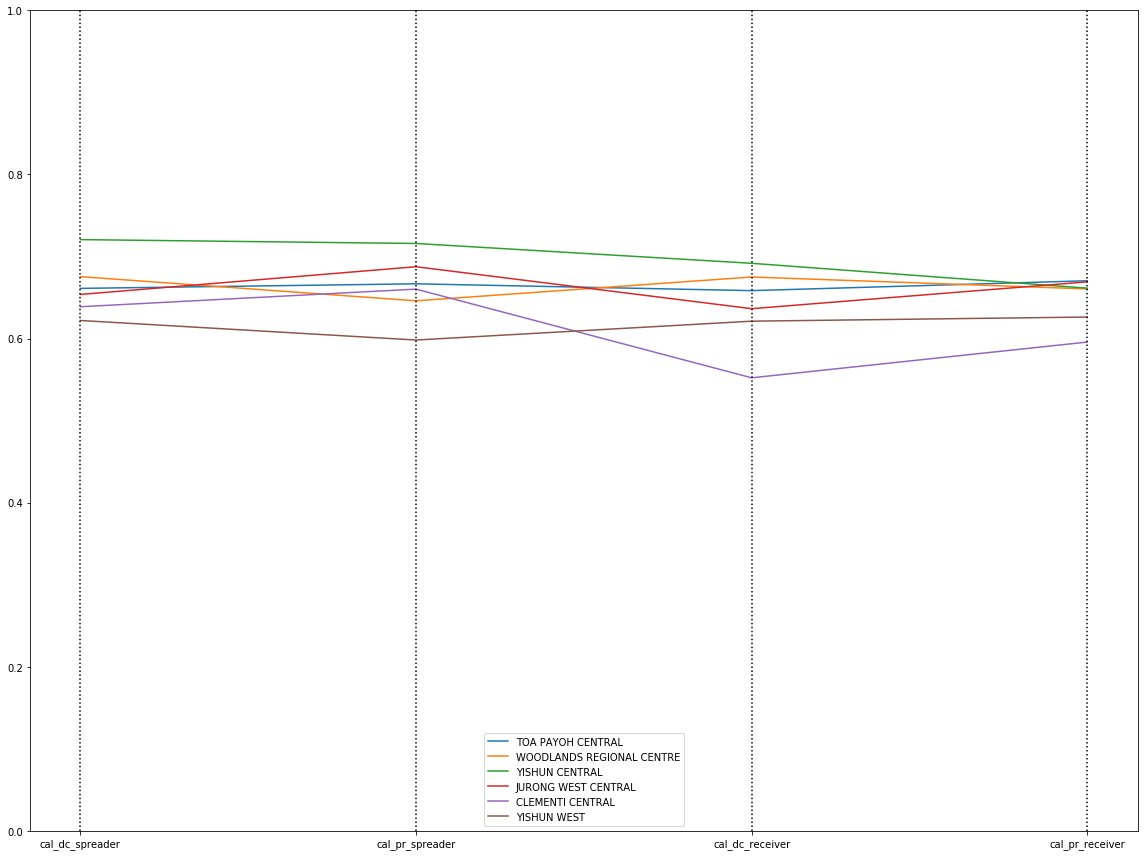

In [90]:
draw_parallel(weekend_res, top=5, cols=['cal_dc_spreader', 'cal_pr_spreader', 'cal_dc_receiver', 'cal_pr_receiver'])#, 'cal_hh',  'cal_ha'])